# Introduction

The timeseries module provides the TimeSeries class which deals with all 1D timeseries (sizedistribution timeseries are considered 2D timeseries and are delt with in a different place). Usually when reading in any type of data, that is in some way a time series it will end up beeing a TimeSeries instance. Data in a TimeSeries is stored at TimeSeries.data in form of a pandas DataFrame instance.

# Imports

In [1]:
from atmPy.instruments.POPS import housekeeping
from atmPy.instruments.piccolo import piccolo
%matplotlib inline

# Some usefull features of the TimeSeries class

## Read (generate) TimeSeries

Usually a TimeSeries is generated when data representing a timeseries is loaded, e.g. POPS housekeeping data, or piccolo telemetry data.

In [18]:
pops_hk = housekeeping.read_csv('./data/POPS_housekeeping.csv')
picco_tel = piccolo.read_csv('./data/piccolo.log')

reading ./data/POPS_housekeeping.csv


## merge TimeSeries instances with different time axes

This attribute of a TimeSeries class allows the projection of a different instance on the current one. The resulting instance will have the collumns of both instances but with the time axes according to the first instance.

In [19]:
pops_hk_merged = pops_hk.merge(picco_tel)
# pops_hk_merged.data

After merging it is possible to plot for example the Particle rate as a function of altitude. Columns which where previously in different Timeseries with different time intervals and time values.

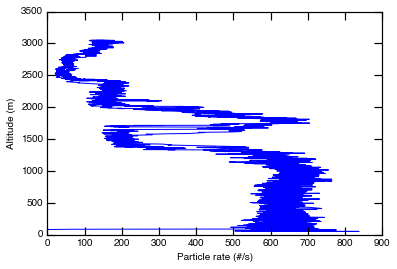

In [32]:
f,ax = plt.subplots()
ax.plot(pops_hk_merged.data.Particle_rate_nops, pops_hk_merged.data.Altitude)
ax.set_ylabel('Altitude (m)')
ax.set_xlabel('Particle rate (#/s)')

## Plot on map

When a TimeSeries instance has data columns named 'Lat' and 'Lon' it is possible to do a quick drowing of e.g. fligh path on a map. This uses matplotlib basemap.

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/mpl_toolkits/basemap/__init__.py:1624: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif fill_color == 'none' or fill_color == 'None':


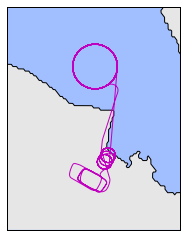

In [36]:
pops_hk_merged.plot_map(resolution = 'f')